# Chapter 14: Association Rules and Collaborative Filtering

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline

from pathlib import Path

import heapq
from collections import defaultdict

import pandas as pd
import matplotlib.pylab as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split


## Table 14.4

In [2]:
# Load and preprocess data set 
fp_df = pd.read_csv('Faceplate.csv')
fp_df.set_index('Transaction', inplace=True)
fp_df

,Red,White,Blue,Orange,Green,Yellow
Transaction,,,,,,
1,1,1,0,0,1,0
2,0,1,0,1,0,0
3,0,1,1,0,0,0
4,1,1,0,1,0,0
5,1,0,1,0,0,0
6,0,1,1,0,0,0
7,1,0,1,0,0,0
8,1,1,1,0,1,0
9,1,1,1,0,0,0


In [3]:
# create frequent itemsets
itemsets = apriori(fp_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(6)

print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

       antecedents   consequents  support  confidence      lift  leverage
12    (White, Red)       (Green)      0.2         0.5  2.500000      0.12
15         (Green)  (White, Red)      0.2         1.0  2.500000      0.12
4          (Green)         (Red)      0.2         1.0  1.666667      0.08
13  (White, Green)         (Red)      0.2         1.0  1.666667      0.08
7         (Orange)       (White)      0.2         1.0  1.428571      0.06
8          (Green)       (White)      0.2         1.0  1.428571      0.06


In [4]:
# filter to get rules with single consequents only
rules[[len(c) == 1 for c in rules.consequents]].sort_values(by=['lift'], ascending=False).head(6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,"(White, Red)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
13,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
14,"(Red, Green)",(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf


The apriori method accepts sparse data frames as well. If we convert the original data frame to sparse format, we can see that the memory requirements go down to 40%. The `fill_value` argument informs the `to_sparse` method here which fields to ignore in each transaction.

In [5]:
# Convert data set into a sparse data frame
sparse_df = fp_df.to_sparse(fill_value=0)
print('Density {}'.format(sparse_df.density))

# create frequent itemsets
itemsets = apriori(sparse_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(6)

Density 0.4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,"(White, Red)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6
15,(Green),"(White, Red)",0.2,0.4,0.2,1.0,2.500000,0.12,inf
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
13,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf


## Data required for Table 14.5 and 14.6

In [6]:
# Prepare the dataset for table 14.6 based on table 14.5
from itertools import chain
randomTransactions = [{8}, {3,4,8}, {8}, {3,9}, {9}, {1,8}, {6,9}, {3,5,7,9}, {8}, set(), 
                      {1,7,9}, {1,4,5,8,9}, {5,7,9}, {6,7,8}, {3,7,9}, {1,4,9}, {6,7,8}, {8}, set(), {9},
                      {2,5,6,8}, {4,6,9}, {4,9}, {8,9}, {6,8}, {1,6,8}, {5,8}, {4,8,9}, {9}, {8},
                      {1,5,8}, {3,6,9}, {7,9}, {7,8,9}, {3,4,6,8}, {1,4,8}, {4,7,8}, {8,9}, {4,5,7,9}, {2,8,9},
                      {2,5,9}, {1,2,7,9}, {5,8}, {1,7,8}, {8}, {2,7,9}, {4,6,9}, {9}, {9}, {6,7,8}]
print(randomTransactions)
uniqueItems = sorted(set(chain.from_iterable(randomTransactions)))
randomData = pd.DataFrame(0, index=range(len(randomTransactions)), columns=uniqueItems)
for row, transaction in enumerate(randomTransactions):
    for item in transaction:
        randomData.loc[row][item] = 1
randomData.head()

[{8}, {8, 3, 4}, {8}, {9, 3}, {9}, {8, 1}, {9, 6}, {9, 3, 5, 7}, {8}, set(), {1, 9, 7}, {1, 4, 5, 8, 9}, {9, 5, 7}, {8, 6, 7}, {9, 3, 7}, {1, 4, 9}, {8, 6, 7}, {8}, set(), {9}, {8, 2, 5, 6}, {9, 4, 6}, {9, 4}, {8, 9}, {8, 6}, {8, 1, 6}, {8, 5}, {8, 9, 4}, {9}, {8}, {8, 1, 5}, {9, 3, 6}, {9, 7}, {8, 9, 7}, {8, 3, 4, 6}, {8, 1, 4}, {8, 4, 7}, {8, 9}, {9, 4, 5, 7}, {8, 9, 2}, {9, 2, 5}, {1, 2, 9, 7}, {8, 5}, {8, 1, 7}, {8}, {9, 2, 7}, {9, 4, 6}, {9}, {9}, {8, 6, 7}]


,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


## Table 14.6

In [7]:
# create frequent itemsets
itemsets = apriori(randomData, min_support=2/len(randomData), use_colnames=True)
# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.7)
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

  antecedents consequents  support  confidence      lift  leverage
3      (8, 3)         (4)     0.04         1.0  4.545455    0.0312
1      (1, 5)         (8)     0.04         1.0  1.851852    0.0184
2      (2, 7)         (9)     0.04         1.0  1.851852    0.0184
4      (3, 4)         (8)     0.04         1.0  1.851852    0.0184
5      (3, 7)         (9)     0.04         1.0  1.851852    0.0184
6      (4, 5)         (9)     0.04         1.0  1.851852    0.0184


## Table 14.8

In [8]:
# load dataset
all_books_df = pd.read_csv('CharlesBookClub.csv')

# create the binary incidence matrix
ignore = ['Seq#', 'ID#', 'Gender', 'M', 'R', 'F', 'FirstPurch', 'Related Purchase',
          'Mcode', 'Rcode', 'Fcode', 'Yes_Florence', 'No_Florence']
count_books = all_books_df.drop(columns=ignore)
count_books[count_books > 0] = 1

count_books.head()

,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeogBks,ItalCook,ItalAtlas,ItalArt,Florence
0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


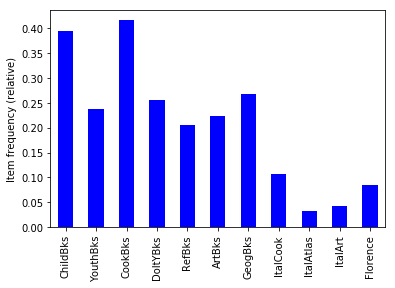

In [9]:
# determine item frequencies
itemFrequency = count_books.sum(axis=0) / len(count_books)

# and plot as histogram
ax = itemFrequency.plot.bar(color='blue')
plt.ylabel('Item frequency (relative)')
plt.show()

In [10]:
# create frequent itemsets and rules
itemsets = apriori(count_books, min_support=200/4000, use_colnames=True)
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)

print('Number of rules', len(rules))

# Display 25 rules with highest lift
rules.sort_values(by=['lift'], ascending=False).head(25)

pd.set_option('precision', 5)
pd.set_option('display.width', 100)
print(rules.sort_values(by=['lift'], ascending=False).drop(columns=['antecedent support', 'consequent support', 'conviction']).head(25))
pd.set_option('precision', 6)

Number of rules 81
                      antecedents          consequents  support  confidence     lift  leverage
64             (RefBks, YouthBks)  (CookBks, ChildBks)  0.05525     0.68000  2.80992   0.03559
73             (RefBks, DoItYBks)  (CookBks, ChildBks)  0.06125     0.66216  2.73621   0.03886
60           (DoItYBks, YouthBks)  (CookBks, ChildBks)  0.06700     0.64891  2.68145   0.04201
80              (RefBks, GeogBks)  (CookBks, ChildBks)  0.05025     0.61468  2.54000   0.03047
69            (GeogBks, YouthBks)  (CookBks, ChildBks)  0.06325     0.60526  2.50109   0.03796
77            (DoItYBks, GeogBks)  (CookBks, ChildBks)  0.06050     0.59901  2.47525   0.03606
65   (CookBks, ChildBks, GeogBks)           (YouthBks)  0.06325     0.57763  2.42445   0.03716
71    (CookBks, RefBks, ChildBks)           (DoItYBks)  0.06125     0.59179  2.32301   0.03488
47            (DoItYBks, GeogBks)           (YouthBks)  0.05450     0.53960  2.26486   0.03044
61    (CookBks, RefBks, ChildBk

In [11]:
# Filter rules by number of antecedents (maximum 2) and consequents (maximum 1)
rules = rules[[len(c) <= 2 for c in rules.antecedents]]
rules = rules[[len(c) == 1 for c in rules.consequents]]

rules.sort_values(by=['lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
47,"(DoItYBks, GeogBks)",(YouthBks),0.10100,0.23825,0.05450,0.539604,2.264864,0.030437,1.654554
34,"(RefBks, ChildBks)",(DoItYBks),0.12825,0.25475,0.07100,0.553606,2.173135,0.038328,1.669490
19,"(ChildBks, GeogBks)",(YouthBks),0.14625,0.23825,0.07550,0.516239,2.166797,0.040656,1.574642
45,"(CookBks, GeogBks)",(YouthBks),0.15625,0.23825,0.08025,0.513600,2.155719,0.043023,1.566098
17,"(ChildBks, YouthBks)",(DoItYBks),0.14750,0.25475,0.08025,0.544068,2.135693,0.042674,1.634563
50,"(CookBks, RefBks)",(DoItYBks),0.13975,0.25475,0.07450,0.533095,2.092619,0.038899,1.596148
23,"(CookBks, ChildBks)",(DoItYBks),0.24200,0.25475,0.12775,0.527893,2.072198,0.066101,1.578560
49,"(GeogBks, YouthBks)",(DoItYBks),0.10450,0.25475,0.05450,0.521531,2.047227,0.027879,1.557573
41,"(CookBks, YouthBks)",(DoItYBks),0.16100,0.25475,0.08375,0.520186,2.041948,0.042735,1.553207
43,"(RefBks, YouthBks)",(CookBks),0.08125,0.41550,0.06825,0.840000,2.021661,0.034491,3.653125


## Section 14.2 Collaborative Filtering

In [12]:
ratings = pd.DataFrame([
    [30878, 1, 4], [30878, 5, 1], [30878, 18, 3], [30878, 28, 3], [30878, 30, 4], [30878, 44, 5], 
    [124105, 1, 4], 
    [822109, 1, 5], 
    [823519, 1, 3], [823519, 8, 1], [823519, 17, 4], [823519, 28, 4], [823519, 30, 5], 
    [885013, 1, 4], [885013, 5, 5], 
    [893988, 1, 3], [893988, 30, 4], [893988, 44, 4], 
    [1248029, 1, 3], [1248029, 28, 2], [1248029, 30, 4], [1248029, 48, 3], 
    [1503895, 1, 4], 
    [1842128, 1, 4], [1842128, 30, 3], 
    [2238063, 1, 3], 
], columns=['customerID', 'movieID', 'rating'])

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['customerID', 'movieID', 'rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine', 'user_based': False}  # compute cosine similarities between items
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
pred = algo.predict(str(823519), str(30), r_ui=4, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
user: 823519     item: 30         r_ui = 4.00   est = 3.54   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


## Table 14.11

In [13]:
import random

random.seed(0)
nratings = 5000
randomData = pd.DataFrame({
    'itemID': [random.randint(0,99) for _ in range(nratings)],
    'userID': [random.randint(0,999) for _ in range(nratings)],
    'rating': [random.randint(1,5) for _ in range(nratings)],
})

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    byUser = defaultdict(list)
    for p in predictions:
        byUser[p.uid].append(p)
    
    # For each user, reduce predictions to top-n
    for uid, userPredictions in byUser.items():
        byUser[uid] = heapq.nlargest(n, userPredictions, key=lambda p: p.est)
    return byUser

# Convert thes data set into the format required by the surprise package
# The columns must correspond to user id, item id and ratings (in that order)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(randomData[['userID', 'itemID', 'rating']], reader)

# Split into training and test set
trainset, testset = train_test_split(data, test_size=.25, random_state=1)

## User-based filtering
# compute cosine similarity between users 
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=4)

# Print the recommended items for each user
print()
print('Top-3 recommended items for each user')
for uid, user_ratings in list(top_n.items())[:5]:
    print('User {}'.format(uid))
    for prediction in user_ratings:
        print('  Item {0.iid} ({0.est:.2f})'.format(prediction), end='')
    print()
print()

    
## Item-based filtering
# compute cosine similarity between users 
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(testset)
top_n = get_top_n(predictions, n=4)

# Print the recommended items for each user
print()
print('Top-3 recommended items for each user')
for uid, user_ratings in list(top_n.items())[:5]:
    print('User {}'.format(uid))
    for prediction in user_ratings:
        print('  Item {0.iid} ({0.est:.2f})'.format(prediction), end='')
    print()

Computing the cosine similarity matrix...


Done computing similarity matrix.



Top-3 recommended items for each user
User 6
  Item 6 (5.00)  Item 77 (2.50)  Item 60 (1.00)
User 222
  Item 77 (3.50)  Item 75 (2.78)
User 424
  Item 14 (3.50)  Item 45 (3.10)  Item 54 (2.34)
User 87
  Item 27 (3.00)  Item 54 (3.00)  Item 82 (3.00)  Item 32 (1.00)
User 121
  Item 98 (3.48)  Item 32 (2.83)

Computing the cosine similarity matrix...
Done computing similarity matrix.

Top-3 recommended items for each user
User 6
  Item 77 (3.00)  Item 60 (3.00)  Item 6 (3.00)
User 222
  Item 77 (2.24)  Item 75 (2.00)
User 424
  Item 54 (3.47)  Item 14 (3.44)  Item 45 (3.00)
User 87
  Item 27 (3.00)  Item 32 (3.00)  Item 82 (3.00)  Item 54 (2.50)
User 121
  Item 32 (3.06)  Item 98 (2.31)


In [14]:
## Build a model using the full dataset
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Predict rating for user 383 and item 7
algo.predict(383, 7)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Prediction(uid=383, iid=7, r_ui=None, est=2.3661840936304324, details={'actual_k': 4, 'was_impossible': False})